In [1]:
import sys
import numpy as np
import tensorflow as tf
import tensorflow.keras as keras
from sklearn.model_selection import StratifiedKFold
from tensorflow.keras.callbacks import EarlyStopping
from PIL import Image
import pickle
import matplotlib.pyplot as plt
import os
import csv

In [2]:
def load_dataset(dataset_dir):
        data = []
        labels = []
        class_dirs = os.listdir(dataset_dir)
        class_dict = {cls: i for i, cls in enumerate(class_dirs)}

        for cls in class_dirs:
            class_dir = os.path.join(dataset_dir, cls)
            class_label = class_dict[cls]

            for image_name in os.listdir(class_dir):
                image_path = os.path.join(class_dir, image_name)

                image = Image.open(image_path).convert("L")
                image = image.resize((32, 32)) 
                image = np.array(image) 
                data.append(image)
                labels.append(class_label)

        data = np.array(data)
        data = data/255
        labels = np.array(labels)

        return data, labels

In [3]:
tf.config.experimental.set_memory_growth(tf.config.experimental.list_physical_devices('GPU')[0], True)

In [4]:
def model1(lr):
    model = keras.Sequential([
        keras.layers.Flatten(),
        keras.layers.Dense(1024, activation='relu'),
        keras.layers.Dense(512, activation='relu'),
        keras.layers.Dense(256, activation='relu'),
        keras.layers.Dense(128, activation='relu'),
        keras.layers.Dense(1, activation='sigmoid')
    ])
    
    opt = keras.optimizers.Adam(learning_rate=lr)
    model.compile(optimizer=opt, loss='binary_crossentropy',metrics=['accuracy'])
    
    return model

In [5]:
def model2(lr):
    model = keras.Sequential([
        keras.layers.Conv2D(16, (3, 3), activation='relu', input_shape=(32, 32, 1)),
        keras.layers.MaxPool2D((2, 2)),
        keras.layers.Conv2D(32, (3, 3), activation='relu'),
        keras.layers.MaxPool2D((2, 2)),
        keras.layers.Flatten(),
        keras.layers.Dense(128, activation='relu'),
        keras.layers.Dense(1, activation='sigmoid')
    ])
    
    opt = keras.optimizers.Adam(learning_rate=lr)
    model.compile(optimizer=opt, loss='binary_crossentropy',metrics=['accuracy'])
    
    return model

In [6]:
def model3(lr):
    model = keras.Sequential([
        keras.layers.Conv2D(64, (3, 3), activation='relu', input_shape=(32, 32, 1)),
        keras.layers.MaxPool2D((2, 2)),
        keras.layers.Conv2D(128, (3, 3), activation='relu'),
        keras.layers.MaxPool2D((2, 2)),
        keras.layers.Flatten(),
        keras.layers.Dense(128, activation='relu'),
        keras.layers.Dense(1, activation='sigmoid')
    ])
    
    opt = keras.optimizers.Adam(learning_rate=lr)
    model.compile(optimizer=opt, loss='binary_crossentropy',metrics=['accuracy'])
    
    return model

In [7]:
def model4(lr):
    model = keras.Sequential([
        keras.layers.Conv2D(16, (3, 3), activation='relu', input_shape=(32, 32, 1)),
        keras.layers.Conv2D(32, (3, 3), activation='relu'),
        keras.layers.Conv2D(64, (3, 3), activation='relu'),
        keras.layers.MaxPool2D((2, 2)),
        keras.layers.Conv2D(128, (3, 3), activation='relu'),
        keras.layers.MaxPool2D((2, 2)),
        keras.layers.Flatten(),
        keras.layers.Dense(128, activation='relu'),
        keras.layers.Dense(1, activation='sigmoid')
    ])
    
    opt = keras.optimizers.Adam(learning_rate=lr)
    model.compile(optimizer=opt, loss='binary_crossentropy',metrics=['accuracy'])
    
    return model

In [33]:
def plot_risks_matrix(model, risks, epochs):
    # Organizza i dati in una matrice
    risks_matrix = np.array(risks).reshape(len(learning_rates), len(batch_size))
    epochs_matrix = np.array(epochs).reshape(len(learning_rates), len(batch_size))

    fig, ax = plt.subplots()

    # Valori sugli assi
    ax.set_xticks(np.arange(len(learning_rates)))
    ax.set_yticks(np.arange(len(batch_size)))
    ax.set_xticklabels(learning_rates)
    ax.set_yticklabels(batch_size)

    # Etichette sugli assi
    plt.xlabel("Learning Rate")
    plt.ylabel("Batch Size")
    plt.title(f"{model.__name__} - Risks for Different Learning Rates and Batch Sizes")

    for i in range(len(learning_rates)):
        for j in range(len(batch_size)):
            text = ax.text(j, i, f"{risks_matrix[i, j]:.4f}\n{epochs_matrix[i, j]}", ha="center", va="center", color="w")

    im = ax.imshow(risks_matrix, cmap="coolwarm", aspect='auto')
    
    #vmin, vmax = risks_matrix.min(), risks_matrix.max()
    im.set_clim(0, 0.5)

    plt.colorbar(im)
    
    plt.savefig(f'graph/{model.__name__}_risks.png')
    plt.show()

In [10]:
def plot_training_validation_loss(model, mean_train_losses, mean_val_losses):
    
    x_labels = [f'LR={lr}, BS={bs}' for bs in batch_size for lr in learning_rates]
    x_values = np.arange(len(x_labels))

    # Create the bar plot
    plt.figure(figsize=(13, 3))  # Optional: Adjust the figure size
    bar_width = 0.2

    for i in range(len(learning_rates) * len(batch_size)):
        label = x_labels[i]
        plt.bar(x_values[i] - bar_width/2, mean_train_losses[i],
                width=bar_width, label=f'Training ({label})', color='blue')
        plt.bar(x_values[i] + bar_width/2, mean_val_losses[i],
                width=bar_width, label=f'Validation ({label})', color='orange')
        
        plt.text(x_values[i] - bar_width/2, max(mean_train_losses[i], mean_val_losses[i]) + 0.02, f'{mean_train_losses[i]:.2f}', ha='center', color='blue')
        plt.text(x_values[i] + bar_width/2, max(mean_train_losses[i], mean_val_losses[i]) + 0.02, f'{mean_val_losses[i]:.2f}', ha='center', color='orange')


    plt.xticks(x_values, x_labels, rotation = 30, ha='center')  # Label with LR and BS values with rotation
    plt.ylabel('Mean Score')
    plt.title(f'{model.__name__} - Mean Training and Validation Loss for Different Hyperparameters')
    plt.ylim(0, 1)  # Adjust the y-axis limits as needed
    #plt.legend()
    plt.tight_layout()  # Optional: Adjusts subplot parameters for a better layout
    plt.savefig(f'graph/{model.__name__}_loss.png')
    plt.show()

In [11]:
def cross_val(model, X, Y, batch_size, learning_rate, patience):
    
    print(f"{model.__name__} batch_size: {batch_size} learning_rate: {learning_rate}")
    
    scores = []
    zero_one_losses = []
    train_loss = []
    val_loss = []
    
    epochs = []
    train_data = []
    val_data = []
    training_acc = []

    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    
    splits = skf.split(X, Y)
    
    early_stopping = EarlyStopping(monitor='val_loss', patience=patience, restore_best_weights=True)

        
    with tf.device('/gpu:0'):
        for fold, (train_index, val_index) in enumerate(splits):

            train_data = X[train_index]
            train_labels = Y[train_index]
            val_data = X[val_index]
            val_labels = Y[val_index]

            print(f"Fold {fold+1}/5")
            actual_model = model(learning_rate)
            history = actual_model.fit(train_data, train_labels, validation_data=(val_data, val_labels), callbacks=[early_stopping], batch_size = batch_size, epochs = 100, verbose=0)
            #score = actual_model.evaluate(val_data, val_labels)
            best_epoch = np.argmin(history.history["val_loss"])
            
            train_loss.append(history.history["loss"][best_epoch])
            val_loss.append(history.history["val_loss"][best_epoch])
            zero_one_loss = 1 - history.history["val_accuracy"][best_epoch]
            training_acc.append(history.history['accuracy'])
            
            zero_one_losses.append(zero_one_loss)
        
            epochs.append(best_epoch + 1)
            print(f"loss: {history.history['loss'][best_epoch]} val_loss: {history.history['val_loss'][best_epoch]} zo_loss: {zero_one_loss} epoch: {best_epoch+1}")

    train_loss_mean = np.mean(train_loss)
    val_loss_mean = np.mean(val_loss)
    risk = np.mean(zero_one_losses)
    epochs_mean = np.mean(epochs)
    print(f"risk estimate: {risk}")
    
    return train_loss_mean, val_loss_mean, risk, epochs_mean, training_acc

In [12]:
def hyperparameter_test_cross_validation(model): 
    risks = []
    mean_train_losses = []
    mean_val_losses = []
    mean_epochs = []
    training_accs = []
    
    for b in batch_size:
        for lr in learning_rates:
            mean_train_loss, mean_val_loss, risk, mean_epoch, training_acc = cross_val(model, X, Y, b, lr, patience)
            f = open("result/result.txt", "a")
            f.write(f"{model.__name__} epochs mean:{mean_epoch} learning rate:{lr} batch size: {b} risk: {risk}\n")
            f.close()
            risks.append(risk)
            mean_train_losses.append(mean_train_loss)
            mean_val_losses.append(mean_val_loss)
            mean_epochs.append(mean_epoch) 
            training_accs.append(training_acc)
            
    
    with open(f'result/{model.__name__}_risks.pkl', 'wb') as file:
        pickle.dump(risks, file)
    
    with open(f'result/{model.__name__}_val.pkl', 'wb') as file:
        pickle.dump(mean_val_losses , file)

    with open(f'result/{model.__name__}_train.pkl', 'wb') as file:
        pickle.dump(mean_train_losses , file)

    with open(f'result/{model.__name__}_epochs.pkl', 'wb') as file:
        pickle.dump(mean_epochs , file)
        
    return mean_train_losses, mean_val_losses, risks, mean_epochs, training_accs

In [13]:
def write_csv(models, risks, epochs):
    if os.path.exists("result/result.csv"):
        os.remove("result/result.csv")
    # Creare un file CSV e scrivere i risultati
    with open("result/result.csv", mode="w", newline="") as csv_file:
        fieldnames = ["Model", "Learning Rate", "Batch Size", "Epochs Mean", "Risk"]
        writer = csv.DictWriter(csv_file, fieldnames=fieldnames, delimiter=';')
        writer.writeheader()

        for i in range(len(batch_size)):
            for j in range(len(learning_rates)):
                for m in range(len(models)):
                    model_name = models[m].__name__
                    epochs_mean = epochs[m][i * len(batch_size) + j]  # Calcola il valore corrispondente alle epoche medie
                    lr = learning_rates[j]
                    bs = batch_size[i]
                    risk = risks[m][i * len(batch_size) + j]
                    writer.writerow({"Model": model_name, "Learning Rate": lr, "Batch Size": bs, "Epochs Mean": epochs_mean, "Risk": risk})


In [45]:
X, Y = load_dataset("data/dataset")
if os.path.exists("result/result.txt"):
    os.remove("result/result.txt")

In [23]:
learning_rates = [0.01, 0.001, 0.0001]
batch_size = [32, 128, 256]
patience = 5

In [48]:
model1_train_loss, model1_val_loss, model1_risks, model1_epochs, model1_train_accs = hyperparameter_test_cross_validation(model1)

model1 batch_size: 32 learning_rate: 0.01
Fold 1/5
loss: 0.6890732645988464 val_loss: 0.6688475608825684 zo_loss: 0.3623310923576355 epoch: 2
Fold 2/5
loss: 0.6832122206687927 val_loss: 0.6654555797576904 zo_loss: 0.44847971200942993 epoch: 2
Fold 3/5
loss: 0.6563612818717957 val_loss: 0.6610009670257568 zo_loss: 0.3964496850967407 epoch: 8
Fold 4/5
loss: 0.6772292256355286 val_loss: 0.6627572774887085 zo_loss: 0.4581572413444519 epoch: 2
Fold 5/5
loss: 0.6723798513412476 val_loss: 0.6495429873466492 zo_loss: 0.4074386954307556 epoch: 6
risk estimate: 0.41457128524780273
model1 batch_size: 32 learning_rate: 0.001
Fold 1/5
loss: 0.5775734186172485 val_loss: 0.5879082083702087 zo_loss: 0.3192567825317383 epoch: 12
Fold 2/5
loss: 0.5876924395561218 val_loss: 0.586063802242279 zo_loss: 0.3082770109176636 epoch: 9
Fold 3/5
loss: 0.581148624420166 val_loss: 0.6064488291740417 zo_loss: 0.34911245107650757 epoch: 9
Fold 4/5
loss: 0.5141220688819885 val_loss: 0.592319130897522 zo_loss: 0.316990

In [50]:
model2_train_loss, model2_val_loss, model2_risks, model2_epochs, model2_train_accs = hyperparameter_test_cross_validation(model2)

model2 batch_size: 32 learning_rate: 0.01
Fold 1/5
loss: 0.6903119087219238 val_loss: 0.6898565292358398 zo_loss: 0.45945948362350464 epoch: 10
Fold 2/5
loss: 0.5042020678520203 val_loss: 0.4873480796813965 zo_loss: 0.23902028799057007 epoch: 5
Fold 3/5
loss: 0.6902225017547607 val_loss: 0.6897857785224915 zo_loss: 0.4590025544166565 epoch: 6
Fold 4/5
loss: 0.6902372241020203 val_loss: 0.6897796988487244 zo_loss: 0.4590025544166565 epoch: 3
Fold 5/5
loss: 0.4782608151435852 val_loss: 0.5334001183509827 zo_loss: 0.2662721872329712 epoch: 13
risk estimate: 0.3765514135360718
model2 batch_size: 32 learning_rate: 0.001
Fold 1/5
loss: 0.2951686382293701 val_loss: 0.37834683060646057 zo_loss: 0.16385138034820557 epoch: 10
Fold 2/5
loss: 0.2631990313529968 val_loss: 0.39208969473838806 zo_loss: 0.17652028799057007 epoch: 12
Fold 3/5
loss: 0.276906281709671 val_loss: 0.3899844288825989 zo_loss: 0.1639898419380188 epoch: 11
Fold 4/5
loss: 0.37018200755119324 val_loss: 0.41023778915405273 zo_los

In [52]:
model3_train_loss, model3_val_loss, model3_risks, model3_epochs, model3_train_accs = hyperparameter_test_cross_validation(model3)

model3 batch_size: 32 learning_rate: 0.01
Fold 1/5
loss: 0.6908090710639954 val_loss: 0.689866304397583 zo_loss: 0.45945948362350464 epoch: 2
Fold 2/5
loss: 0.4677812159061432 val_loss: 0.49293574690818787 zo_loss: 0.2373310923576355 epoch: 7
Fold 3/5
loss: 0.6904585361480713 val_loss: 0.6897823214530945 zo_loss: 0.4590025544166565 epoch: 5
Fold 4/5
loss: 0.4628285765647888 val_loss: 0.4899747967720032 zo_loss: 0.24260354042053223 epoch: 12
Fold 5/5
loss: 0.552718997001648 val_loss: 0.5783893465995789 zo_loss: 0.28994083404541016 epoch: 13
risk estimate: 0.3376675009727478
model3 batch_size: 32 learning_rate: 0.001
Fold 1/5
loss: 0.2082299292087555 val_loss: 0.38166794180870056 zo_loss: 0.1427364945411682 epoch: 11
Fold 2/5
loss: 0.3292144536972046 val_loss: 0.37511205673217773 zo_loss: 0.17145270109176636 epoch: 8
Fold 3/5
loss: 0.2723671793937683 val_loss: 0.37417900562286377 zo_loss: 0.15976333618164062 epoch: 9
Fold 4/5
loss: 0.32632043957710266 val_loss: 0.40692806243896484 zo_los

In [56]:
model4_train_loss, model4_val_loss, model4_risks, model4_epochs, model4_train_accs = hyperparameter_test_cross_validation(model4)

model4 batch_size: 32 learning_rate: 0.01
Fold 1/5
loss: 0.6903401613235474 val_loss: 0.6898594498634338 zo_loss: 0.45945948362350464 epoch: 3
Fold 2/5
loss: 0.6901302933692932 val_loss: 0.6898569464683533 zo_loss: 0.45945948362350464 epoch: 11
Fold 3/5
loss: 0.6902607679367065 val_loss: 0.6897842288017273 zo_loss: 0.4590025544166565 epoch: 9
Fold 4/5
loss: 0.7498884797096252 val_loss: 0.689784049987793 zo_loss: 0.4590025544166565 epoch: 1
Fold 5/5
loss: 0.6905896067619324 val_loss: 0.6899381279945374 zo_loss: 0.4598478674888611 epoch: 2
risk estimate: 0.45935438871383666
model4 batch_size: 32 learning_rate: 0.001
Fold 1/5
loss: 0.3070012927055359 val_loss: 0.37574541568756104 zo_loss: 0.1613175868988037 epoch: 7
Fold 2/5
loss: 0.3715292811393738 val_loss: 0.42298102378845215 zo_loss: 0.20270270109176636 epoch: 5
Fold 3/5
loss: 0.3140844404697418 val_loss: 0.36652672290802 zo_loss: 0.15553677082061768 epoch: 7
Fold 4/5
loss: 0.288739413022995 val_loss: 0.4327409267425537 zo_loss: 0.187

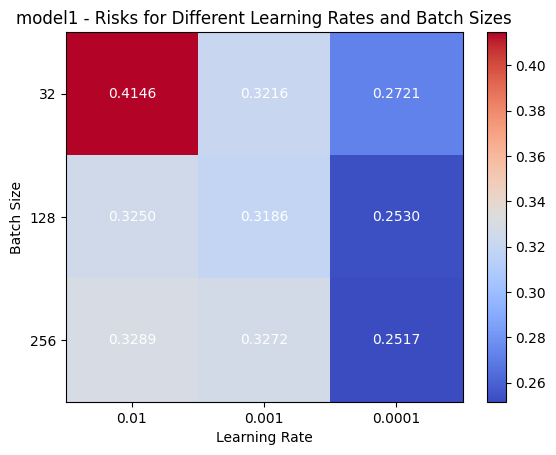

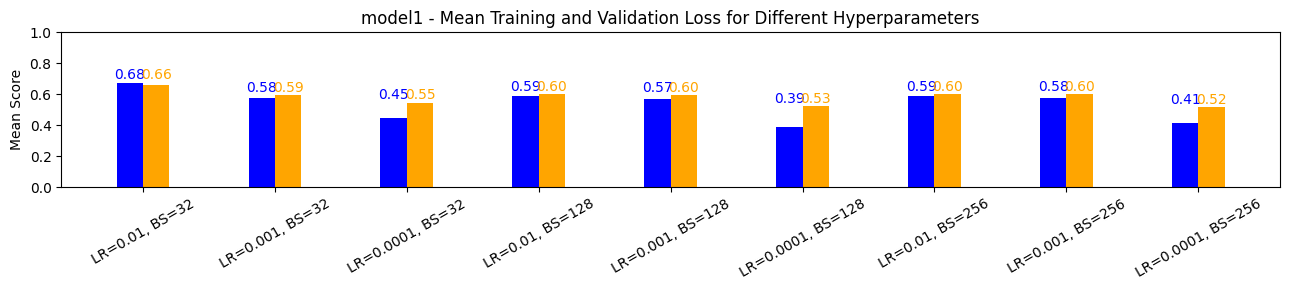

In [49]:
plot_risks_matrix(model1, model1_risks, model1_epochs)
plot_training_validation_loss(model1, model1_train_loss, model1_val_loss)

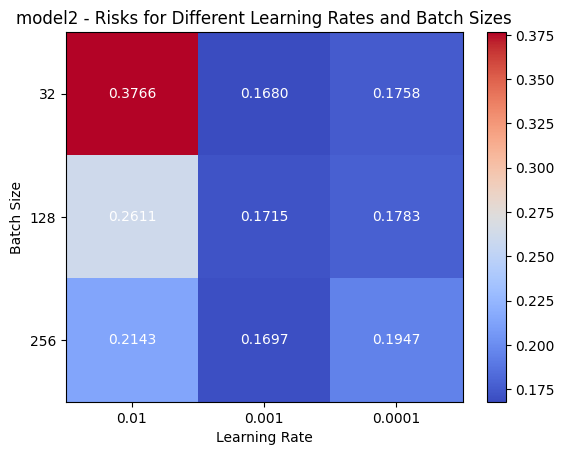

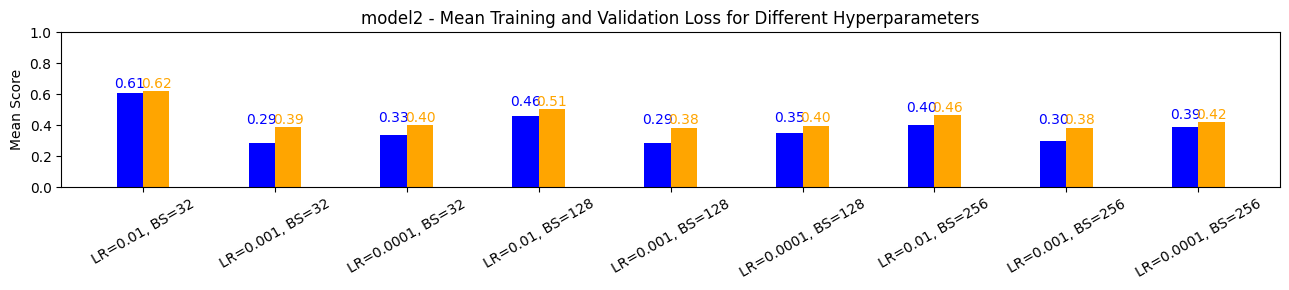

In [51]:
plot_risks_matrix(model2, model2_risks, model2_epochs)
plot_training_validation_loss(model2, model2_train_loss, model2_val_loss)

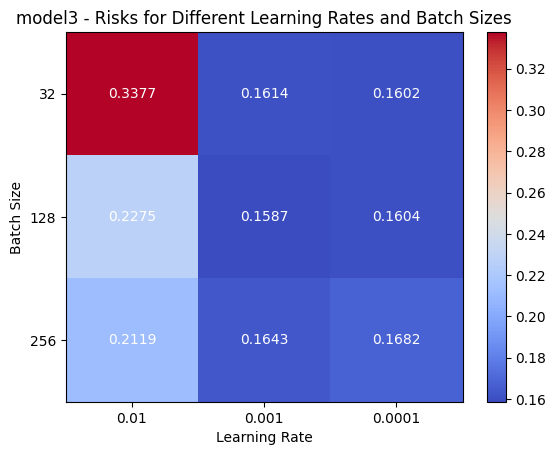

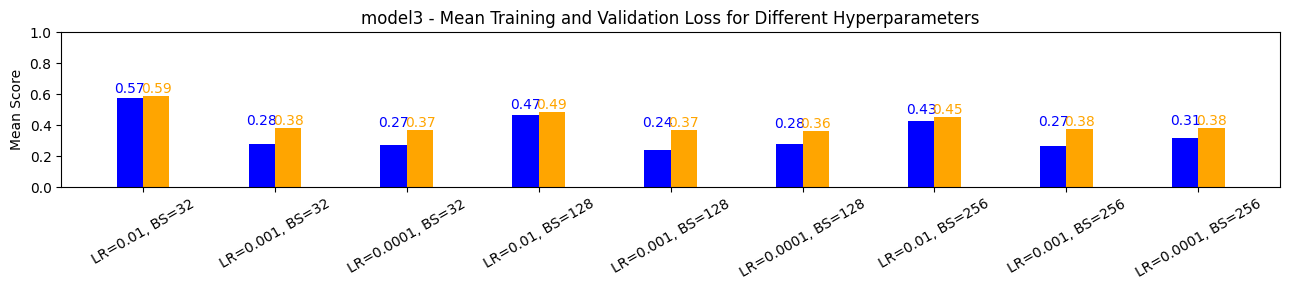

In [53]:
plot_risks_matrix(model3, model3_risks, model3_epochs)
plot_training_validation_loss(model3, model3_train_loss, model3_val_loss)

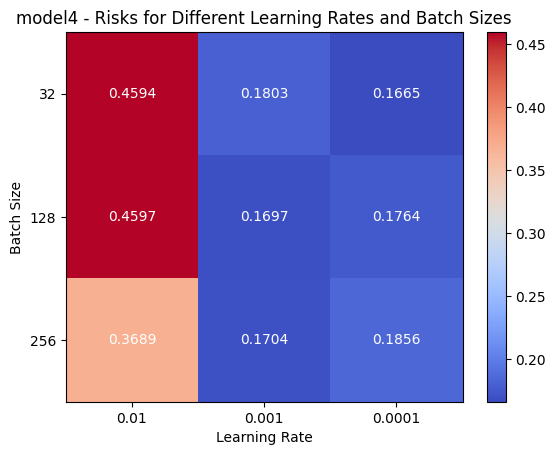

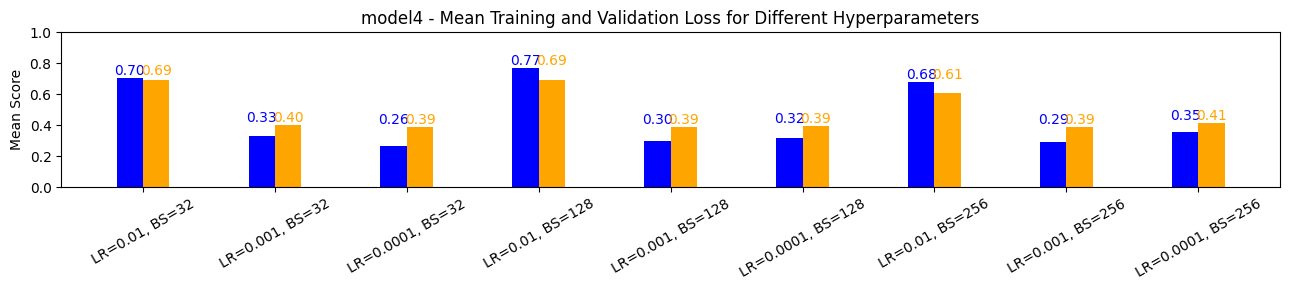

In [57]:
plot_risks_matrix(model4, model4_risks, model4_epochs)
plot_training_validation_loss(model4, model4_train_loss, model4_val_loss)

In [59]:
models = [model1, model2, model3, model4]
risks = [model1_risks, model2_risks, model3_risks, model4_risks]
epochs = [model1_epochs, model2_epochs, model3_epochs, model4_epochs]

write_csv(models, risks, epochs)